In [1]:
using CSV, DataFrames

[ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]


In [2]:
using JuMP, Gurobi

[ Info: Precompiling Gurobi [2e9cd046-0924-5485-92f1-d5272153d98b]


In [3]:
using Plots

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [4]:
employee_data = CSV.File("employee_data.csv") |> DataFrame
employee_data = select(employee_data, Not(:Employee_ID))
employee_data.RowIndex = 1:nrow(employee_data)

1:2283

In [5]:
demand_data = CSV.File("demand_data.csv") |> DataFrame
demand_data = demand_data[:, 1:4]

Row,Department,Level,Min_Num_Employees,Max_Num_Employees
,Int64,Int64,Int64,Int64
1,1,1,60,80
2,2,1,65,80
3,3,1,35,70
4,4,1,60,84
5,5,1,8,73
6,1,2,55,80
7,2,2,70,90
8,3,2,40,80
9,4,2,74,86


In [6]:
dropmissing!(employee_data)
dropmissing!(demand_data); 

## Baseline

In [7]:
function optimize_employee_allocation_baseline(employee_data, demand_data; total_employees_limit=1500)
    # Convert to DataFrame for easier handling
    E = DataFrame(employee_data)
    D = DataFrame(demand_data)

    # Sort employees within each department and level by years at the company
    sort!(E, [:Department, :Level_in_Company, :Years_at_Company], rev=true)

    # Initialize the selection variable directly
    E.Selected = falses(size(E, 1))

    # Function to select employees for a department and level
    function select_employees(dept, level, max_select)
        dept_level_filter = (E.Department .== dept) .& (E.Level_in_Company .== level)
        dept_lvl_employees = findall(dept_level_filter)
        selected_count = 0

        for i in dept_lvl_employees
            if selected_count < max_select
                E[i, :Selected] = true
                selected_count += 1
            else
                break
            end
        end

        return selected_count
    end

    # First, meet the minimum demand for each department and level
    for dept in unique(E.Department)
        for level in unique(E.Level_in_Company)
            min_demand = D[(D.Department .== dept) .& (D.Level .== level), :Min_Num_Employees][1]
            select_employees(dept, level, min_demand)
        end
    end

    # Check how many employees have been selected and how many can still be selected
    total_selected = sum(E.Selected)
    remaining_capacity = total_employees_limit - total_selected

    # If there is remaining capacity, distribute it to meet maximum demands
    if remaining_capacity > 0
        for dept in unique(E.Department)
            for level in unique(E.Level_in_Company)
                max_demand = D[(D.Department .== dept) .& (D.Level .== level), :Max_Num_Employees][1]
                already_selected = sum((E.Department .== dept) .& (E.Level_in_Company .== level) .& E.Selected)
                additional_needed = max_demand - already_selected

                if additional_needed > 0
                    select_employees(dept, level, min(remaining_capacity, additional_needed))
                    total_selected = sum(E.Selected)
                    remaining_capacity = total_employees_limit - total_selected
                end

                if remaining_capacity <= 0
                    break
                end
            end
            if remaining_capacity <= 0
                break
            end
        end
    end
    
    selected_summary = groupby(E, [:Department, :Level_in_Company])
    for group in selected_summary
        dept = group.Department[1]
        level = group.Level_in_Company[1]
        selected_count = sum(group.Selected)
#         println("Department: ", dept, ", Level: ", level, ", Selected: ", selected_count)
    end

    # Return the indices of selected employees
    return findall(E.Selected)
end


out = optimize_employee_allocation_baseline(employee_data, demand_data; total_employees_limit=1500)

1257-element Vector{Int64}:
    1
    2
    3
    4
    5
    6
    7
    8
    9
   10
   11
   12
   13
    ⋮
 2082
 2083
 2084
 2085
 2086
 2087
 2088
 2089
 2090
 2091
 2092
 2093

## Master function

In [41]:
function optimal_employee_allocation(employee_data, demand_data; nlevels=5, ndept=5, M=10000000, min_score=4.0, eps=100, total_employees_limit=1500,  diversity=false, score=false)
    n = nrow(employee_data)
    E = Matrix(employee_data)
    R = E[:, 4]
    C = E[:, 3]
    S = E[:, 11]
    Sc = E[:,6]
    D = demand_data
    D_min = zeros(Int64, ndept, nlevels)
    D_max = zeros(Int64, ndept, nlevels)
    for j in 1:ndept
        for k in 1:nlevels
            Djk = D[(D.Department .== j) .& (D.Level .== k),:]
            if size(Djk)[1] != 0
                D_min[j,k] = first(Djk.Min_Num_Employees)
                D_max[j,k] = first(Djk.Max_Num_Employees)
            end
        end
    end
    BB = [[Matrix(employee_data[(employee_data.Department .== department) .& (employee_data.Level_in_Company .== level),:])[:,1] for level in 1:nlevels] for department in 1:ndept]
    company_A = employee_data[employee_data.Company .== 1,:]
    company_B = employee_data[employee_data.Company .== 2,:]
    A = Matrix(company_A)[:,1]
    B = Matrix(company_B)[:,1]
    
    model = Model(Gurobi.Optimizer)
    @variable(model, X[1:n]>=0)

    @objective(model, Max, sum(R[i]X[i] - C[i]*X[i] - S[i]*(1-X[i]) for i in 1:n))
    
    @constraint(model, [j in 1:n], X[j] <= 1)
    @constraint(model, total_employees, sum(X[i] for i in 1:n) <= total_employees_limit)
    
    @constraint(model, min_demand_dept[j in 1:ndept, k in 1:nlevels], sum(X[i] for i in BB[1][2]) >= D_min[j,k])
    @constraint(model, max_demand_dept[j in 1:ndept, k in 1:nlevels], sum(X[i] for i in BB[1][2]) >= D_max[j,k])
   
    if diversity
        @constraint(model, sum(X[i] for i in 1:n if employee_data[i, :Gender] == "Female") >= 0.4 * n)
        @constraint(model, sum(X[i] for i in 1:n if employee_data[i, :Gender] == "Female") <= 0.6 * n)
#         @constraint(model, sum(X[i] for i in 1:n if employee_data[i, :Race] == "African American") >= 0.15 * n)
#         @constraint(model, sum(X[i] for i in 1:n if employee_data[i, :Race] == "Hispanic") >= 0.15 * n)
#         @constraint(model, sum(X[i] for i in 1:n if employee_data[i, :Race] == "Other") >= 0.05 * n)
        @constraint(model, sum(X[i] for i in 1:n if employee_data[i, :Race] != "Caucasian") >= 0.6 * n)
        
    end
    
    if score
        @constraint(model, min_score_employee[i in 1:n], X[i] * Sc[i] >= min_score - M*(1-X[i]))
    end
    
    optimize!(model)
    
    return value.(X), objective_value(model)
end

optimal_employee_allocation (generic function with 1 method)

In [42]:
# Computing objective value of the baseline function
not_hired = []
for i in 1:nrow(employee_data)
    if !(i in out)
        push!(not_hired,i)
    end
end
objective_baseline = sum(employee_data[i,:Revenue] for i in out) -sum(employee_data[i,:Salary] for i in out) - sum(employee_data[i, :Severance_estimate] for i in not_hired)


# Computing objective value of simple model
employees1, objective_model1 = optimal_employee_allocation(employee_data, demand_data)

# Computing objective value of the model taking diverstiy into account (other,caucasian)
employees2, objective_model2 = optimal_employee_allocation(employee_data, demand_data, diversity = true)

# Computing objective value of the model taking scores into account (all except caucasian)
employees3, objective_model3 = optimal_employee_allocation(employee_data, demand_data, diversity = true, score=false)

# Computing objective value of the model taking scores and diversity into account, caucasian and gender
employees4, objective_model4 = optimal_employee_allocation(employee_data, demand_data, diversity = true)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2201 rows, 2147 columns and 8166 nonzeros
Model fingerprint: 0x48e09ceb
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 3e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+03]
Presolve removed 2198 rows and 66 columns
Presolve time: 0.00s
Presolved: 3 rows, 2081 columns, 4853 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.1776645e+08   2.356014e+03   0.000000e+00      0s
      11    1.5689455e+07   0.000000e+00   0.000000e+00      0s

Solved in 11 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.568945479e+07

User-callback calls 53, time in user-callback 0.00 sec


([1.0, 0.8932038834951457, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0], 1.5689454791318879e7)

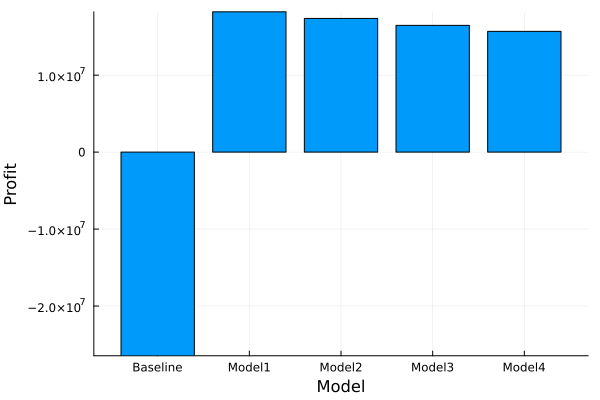

In [43]:
categories = ["Baseline", "Model1", "Model2", "Model3", "Model4"]
values = [objective_baseline, objective_model1, objective_model2, objective_model3, objective_model4]

bar(categories, values, xlabel="Model", ylabel="Profit", title="", legend=false)

In [45]:
temp = employees1 .+ employees2 .+ employees3 .+ employees4
indices = findall(x -> x >0 && x<= 3, temp)


398-element Vector{Int64}:
    1
    3
    6
    7
    8
   16
   18
   25
   26
   27
   30
   32
   34
    ⋮
 2001
 2002
 2010
 2013
 2039
 2054
 2060
 2100
 2104
 2124
 2125
 2135

### Analyzing employees that were never picked

In [46]:
indices_never = findall(x -> x ==0, temp)
data_never_picked = employee_data[indices_never, :]

result = [i in indices_never ? 1 : 0 for i in 1:nrow(employee_data)]
employee_data[!, :NeverPicked] = result
employee_data

Row,Level_in_Company,Company,Salary,Revenue,Department,Score_Review,Age,Years_at_Company,Race,Gender,Severance_estimate,RowIndex,NeverPicked
,Int64,String1,Float64,Float64,Int64,Int64,Int64,Int64,String31,String7,Float64,Int64,Int64
1,1,B,33285.5,16587.8,2,4,27,1,African American,Female,14258.9,1,0
2,1,B,10281.4,9813.93,1,1,27,3,Caucasian,Female,3768.48,2,0
3,1,A,18312.4,14396.4,1,5,27,3,Caucasian,Male,5624.81,3,0
4,1,A,5154.46,31821.6,2,5,27,3,Other,Female,2265.83,4,0
5,1,B,2424.3,1359.47,3,4,27,2,Hispanic,Female,6071.32,5,0
6,1,A,12890.4,9990.05,5,1,27,1,Hispanic,Male,6918.0,6,0
7,1,B,17130.4,19409.6,2,1,27,2,African American,Male,4808.87,7,0
8,1,B,37529.4,16934.8,3,5,27,2,Other,Male,19913.7,8,0
9,1,A,32126.1,6816.33,3,1,27,2,Caucasian,Female,13029.6,9,1


In [47]:
CSV.write("employee_data_modified.csv", employee_data)

"employee_data_modified.csv"

# Financial Health Optimization

In [ ]:
financial_data = CSV.read("financial_data.csv", DataFrame)

n = 1:size(financial_data)[1]
m = 1:size(financial_data)[1]

## Baseline Model

In [63]:
function optimize_financial_health_baseline(financial_data, UB, LB)
    # Convert to DataFrame for easier handling
    F = DataFrame(financial_data)
    n_assets = nrow(F)  # Get the number of assets
    asset_values = F[!, 3]  # Assuming the third column has asset values
    
    # Get the indices of sorted assets
    sorted_asset_indices = sortperm(asset_values, rev=true)

    # Initialize selection array for assets (X)
    X = falses(n_assets)

    # Select top assets up to UB
    for i in 1:min(UB, n_assets)
        X[sorted_asset_indices[i]] = true
    end

    # Creating an array of half the value of selected assets
    debt = [X[i] ? asset_values[i] / 2 : 0 for i in 1:n_assets]
    equity = [X[i] ? asset_values[i] / 2 : 0 for i in 1:n_assets]
    
    return X, debt, equity, 2 * sum(debt)
end


optimize_financial_health_baseline(financial_data, 10, 5)

(Bool[1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0], Real[202855.5, 0, 0, 229041.5, 229891.5, 202068.5, 0, 0, 237282.0, 0, 0, 231672.5, 0, 0, 214921.5, 216376.0, 0, 223055.0, 247543.5, 0], Real[202855.5, 0, 0, 229041.5, 229891.5, 202068.5, 0, 0, 237282.0, 0, 0, 231672.5, 0, 0, 214921.5, 216376.0, 0, 223055.0, 247543.5, 0], 4.469415e6)

In [66]:
function balance_sheet_optimization(financial_data, equity_max=2000000)
    n = nrow(financial_data)
    F = Matrix(financial_data)
    V = F[:, 3]
    model = Model(Gurobi.Optimizer)
    
    @variable(model, X[1:n], Bin)
    @variable(model, L[1:n] >=0)
    @variable(model, S[1:n] >=0)
    
    
    @constraint(model, [i in 1:n], V[i] * X[i] == L[i]* X[i] + S[i] * X[i])
    @constraint(model, liquidity, sum(V[i] * X[i] for i in 1:n) >= sum(L[i]*X[i] for i in 1:n))
    @constraint(model, solvency, sum(L[i] * X[i] for i in 1:n) <= sum(S[i]*X[i] for i in 1:n))
    @constraint(model, sum(S[i] for i in 1:n) <= equity_max)
    
    @objective(model, Max, sum(V[i] * X[i] for i in 1:n))
    
    optimize!(model)
    
    return value.(X), value.(L), value.(S), objective_value(model)
end

balance_sheet_optimization (generic function with 2 methods)

In [51]:
financial_data = CSV.read("Financial_data.csv", DataFrame)

balance_sheet_optimization(financial_data)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 60 columns and 20 nonzeros
Model fingerprint: 0x7781128c
Model has 22 quadratic constraints
Variable types: 40 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+05, 5e+05]
  Objective range  [2e+05, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+06, 2e+06]
Found heuristic solution: objective -0.0000000
Presolve time: 0.01s
Presolved: 123 rows, 140 columns, 400 nonzeros
Presolved model has 40 SOS constraint(s)
Variable types: 100 continuous, 40 integer (40 binary)

Root relaxation: objective 4.000000e+06, 18 iterations, 0.00 seconds (0.00 work units)

    Nodes    

([1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 287882.5, 0.0, 320760.0, 463345.0, 0.0, 0.0, 0.0, 432752.0, 0.0, 0.0, 495087.0, 0.0], [405711.0, 217952.0, 252315.0, 0.0, 0.0, 404137.0, 0.0, 0.0, 186681.5, 0.0, 0.0, 0.0, 0.0, 182457.0, 0.0, 0.0, 0.0, 0.0, 0.0, 350573.0], 3.999653e6)

In [68]:
balance_sheet_optimization(financial_data, 1000000)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 60 columns and 20 nonzeros
Model fingerprint: 0x407d083a
Model has 22 quadratic constraints
Variable types: 40 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+05, 5e+05]
  Objective range  [2e+05, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+06, 1e+06]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 123 rows, 140 columns, 400 nonzeros
Presolved model has 40 SOS constraint(s)
Variable types: 100 continuous, 40 integer (40 binary)

Root relaxation: objective 2.000000e+06, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    

([1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, -3.552713678800501e-15, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], [307428.9999999994, 217952.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 474564.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -9.205969320191798e-13, 0.0, 0.0, 0.0], [98282.00000000063, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 463345.0, -1.2536816029751208e-9, 182457.0, 0.0, 0.0, 255861.0, 0.0, 0.0, 0.0], 1.9998899999999988e6)

In [69]:
balance_sheet_optimization(financial_data, 3000000)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-22
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 60 columns and 20 nonzeros
Model fingerprint: 0x10b58202
Model has 22 quadratic constraints
Variable types: 40 continuous, 20 integer (20 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [2e+05, 5e+05]
  Objective range  [2e+05, 5e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+06, 3e+06]
Found heuristic solution: objective -0.0000000
Presolve time: 0.00s
Presolved: 123 rows, 140 columns, 400 nonzeros
Presolved model has 40 SOS constraint(s)
Variable types: 100 continuous, 40 integer (40 binary)

Root relaxation: objective 6.000000e+06, 21 iterations, 0.00 seconds (0.00 work units)

    Nodes    

([0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0], [0.0, 0.0, 0.0, 0.0, 349155.0, 404137.0, 0.0, 0.0, 474564.0, 0.0, 0.0, 463345.0, 0.0, 0.0, 429843.0, 432752.0, 0.0, 446110.0, 0.0, 0.0], [0.0, 217952.0, 0.0, 458083.0, 110628.0, 0.0, 222579.0, 213817.0, 0.0, 311543.0, 320760.0, 0.0, 355653.0, 182457.0, 0.0, 0.0, 255861.0, 0.0, 0.0, 350573.0], 5.999812e6)